In [4]:
import keras
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.layers import Conv1D, Dense, Input, Concatenate, Reshape, Lambda
from keras.utils import plot_model
from scipy import stats as ss
from IPython.core.display import Image

Using TensorFlow backend.


In [5]:
def create_model(n_samples, kernel_size):
    # Ratio should be 0 < x < 1, add check later on.
    # Model parameters:
    N_DENSE_1 = 10  # Other parameters don't depend on this one.
    N_DENSE_2 = 40 
    
    N_IN_DENSE = int(np.ceil((n_samples + kernel_size) / N_DENSE_2))
    N_LEN = N_IN_DENSE * N_DENSE_2
    KERNEL_SIZE = N_LEN - n_samples + 1

    print("N_DENSE_1:", N_DENSE_1, "\nN_DENSE_2:", N_DENSE_2, "\nN_IN_DENSE:", N_IN_DENSE, "\nN_LEN:",
          N_LEN, "\nKERNEL_SIZE:", KERNEL_SIZE)
    
    model = Input(shape=(1,), name='input')
    print("Shape after input:", model.shape)
    
    layer_1 = []
    layer_2 = []
    
    for i in range(N_IN_DENSE): # N_IN_DENSE * N_DENSE_2 - kernel_size of conv = n_samples
        layer_1.append(Dense(N_DENSE_1, activation='relu', name='layer_1_{:02d}'.format(i))(model))
        layer_2.append(Dense(N_DENSE_2, activation='relu', name='layer_2_{:02d}'.format(i))(layer_1[-1]))
    
    concat = Concatenate()(layer_2)
    print("Shape after concat:", concat.shape)
    
    reshape = Reshape(target_shape=(N_LEN, 1))(concat)
    print("Shape after reshape:", reshape.shape)
    
    # A higher number of filters eliminates the plateau.
    conv = Conv1D(filters=15, kernel_size=KERNEL_SIZE, strides=1)(reshape)
    print("Kernel size:", KERNEL_SIZE)
    print("Shape after conv1d:", conv.shape)
    
    avg = Lambda(lambda x: K.sum(x, axis=2), output_shape=lambda s: (s[0], s[1]))(conv)
    print("Shape after avg:", avg.shape)
    
    model = keras.Model(model, avg)
    
    return model

In [6]:
# Parameters to set.
N_DATA = 10000  # Number of parameter samples
N_SAMPLES = 1000  # Number of data samples

# Parameter-specific settings.
MIN_MU, MAX_MU = -3, 3
MIN_X, MAX_X = -10, 10

In [7]:
# Generate spaces.
mu = np.linspace(MIN_MU, MAX_MU, N_DATA)
x = np.linspace(MIN_X, MAX_X, N_SAMPLES)

# Transform mu to match input format.
mu = mu[:, np.newaxis]

# Sample from standard normal distribution.
x_sampled = ss.norm(mu).logpdf(x[np.newaxis, :])

In [8]:
model = create_model(N_SAMPLES, 200)

plot_model(model, to_file='model.png')
Image(retina=True, filename='model.png')

model.compile(optimizer='adam',
              loss='mean_squared_error')

# What is an acceptable time for fitting?
model.fit(mu, x_sampled, shuffle=True, batch_size=25, epochs=5)

N_DENSE_1: 10 
N_DENSE_2: 40 
N_IN_DENSE: 30 
N_LEN: 1200 
KERNEL_SIZE: 201
Shape after input: (?, 1)
Instructions for updating:
Colocations handled automatically by placer.
Shape after concat: (?, 1200)
Shape after reshape: (?, 1200, 1)
Kernel size: 201
Shape after conv1d: (?, 1000, 15)
Shape after avg: (?, 1000)
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
10000/10000 [==============================] - 5s 522us/step - loss: 69.8026
Epoch 2/5
10000/10000 [==============================] - 4s 407us/step - loss: 0.2620
Epoch 3/5
10000/10000 [==============================] - 4s 404us/step - loss: 0.0745
Epoch 4/5
10000/10000 [==============================] - 4s 408us/step - loss: 0.0410
Epoch 5/5
10000/10000 [==============================] - 4s 407us/step - loss: 0.0254


In [9]:
predictions = model.predict(mu)

array([-1.79987999])

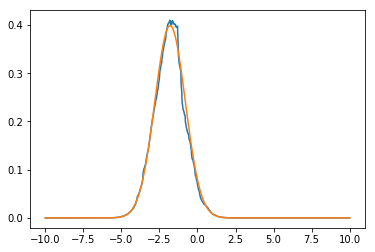

In [10]:
ix = 2000
plt.plot(x, np.exp(predictions[ix, :]))
plt.plot(x, np.exp(x_sampled[ix, :]))
mu[ix]